# DEM post-processing: vertical adjustment with GCPs and error assessment

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xdem
import geoutils as gu
import json
import glob
import sys
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Import processing utility functions
code_dir = "/Users/raineyaberle/Research/PhD/SnowDEMs/skysat_stereo_snow"
sys.path.append(os.path.join(code_dir, 'skysat_stereo_snow'))
import post_process_utils as pp

# Define paths to input files
data_dir = f"/Volumes/LaCie/raineyaberle/Research/PhD/Skysat-Stereo/study-sites/"
site_name = "MCS"
date = "20240420"

if site_name=='MCS':
    dem_fn = os.path.join(data_dir, site_name, date, f"coregAll_ba-u5m_2baRounds_{site_name}_{date}_DEM.tif")
else:
    dem_fn = os.path.join(data_dir, site_name, date, f"coreg-ss-individual_{site_name}_{date}_DEM.tif")
ss_mask_fn = os.path.join(data_dir, site_name, date, "land_cover_masks", "stable_surfaces_mask.tif")
snow_mask_fn = os.path.join(data_dir, site_name, date, "land_cover_masks", "snow_mask.tif")
if site_name=='JacksonPeak':
    refdem_fn = os.path.join(data_dir, site_name, "refdem", "USGS_LPC_ID_FEMAHQ_2018_D18_merged_filtered_UTM11_filled.tif")
    gcp_fn = os.path.join(data_dir, site_name, "snotel", "JacksonPeak_snotel_site_info.gpkg")
    gcp_elev = 1.45
else:
    refdem_fn = os.path.join(data_dir, site_name, 'refdem', f'{site_name}_REFDEM_WGS84.tif')
    gcp_fn = "/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/ITD_Functional_Class/ITD_HWY_21.shp"
    gcp_elev = 0
out_dir = os.path.join(data_dir, site_name, date, "post_process")

# Check that input files exist
for file, name in [[dem_fn, 'DEM'], [refdem_fn, 'Reference DEM'], [ss_mask_fn, 'Stable surfaces'], 
                   [snow_mask_fn, 'Snow mask'], [gcp_fn, "GCP"]]:
    if not os.path.exists(file):
        print(f"{name} not found, please fix before continuing")

# Make output directory
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

## Vertical shift using ground control points (GCPs)

Vertical shift = -0.07 m


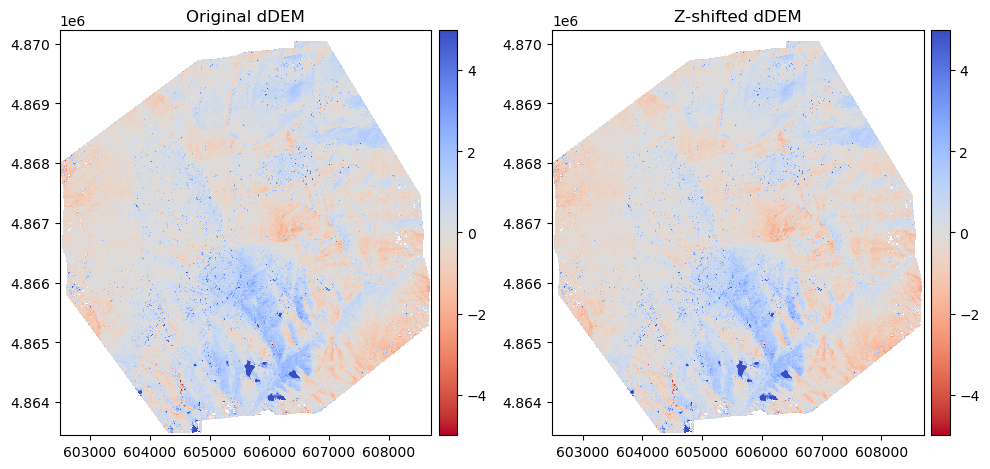

Z-Shifted DEM saved to file: /Volumes/LaCie/raineyaberle/Research/PhD/Skysat-Stereo/study-sites/MCS/20240420/post_process/coregAll_ba-u5m_2baRounds_MCS_20240420_DEM_GCPshift.tif


In [4]:
dem_zshift_fn = os.path.join(out_dir, os.path.splitext(os.path.basename(dem_fn))[0] + '_GCPshift.tif')
if not os.path.exists(dem_zshift_fn):
    # Load input files
    dem = xdem.DEM(dem_fn, load_data=True)
    refdem = xdem.DEM(refdem_fn, load_data=True).reproject(dem)
    gcp = gu.Vector(gcp_fn).reproject(dem)
    if site_name=='JacksonPeak':
        gcp = gcp.buffer(4)
    gcp = gcp.create_mask(dem)
    
    # Calculate dDEM
    ddem = dem - refdem
    
    # Apply vertical shift to DEM using GCP
    shift = xdem.coreg.VerticalShift().fit(refdem, dem, gcp)
    zshift = shift.meta['outputs']['affine']['shift_z'] + gcp_elev
    print(f"Vertical shift = {np.round(float(zshift),2)} m")
    dem_zshift = dem + zshift   
    ddem_zshift = ddem + zshift
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ddem.plot(cmap='coolwarm_r', vmin=-5, vmax=5, ax=ax[0])
    ax[0].set_title('Original dDEM')
    ddem_zshift.plot(cmap='coolwarm_r', vmin=-5, vmax=5, ax=ax[1])
    ax[1].set_title('Z-shifted dDEM')
    plt.show()
    
    # Save results to file
    dem_zshift.save(dem_zshift_fn)
    print('Z-Shifted DEM saved to file:', dem_zshift_fn)

else:
    dem_zshift = xdem.DEM(dem_zshift_fn)
    print('Z-Shifted DEM loaded from file.')
    

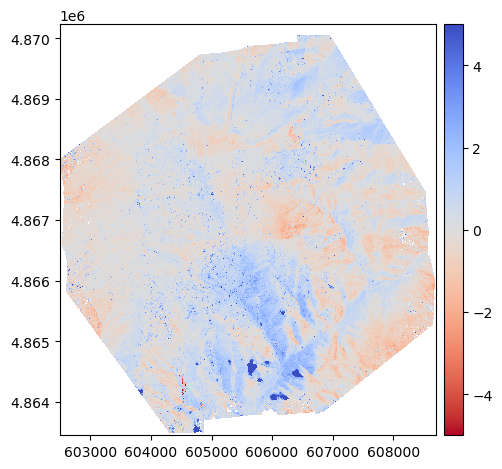

In [5]:
ss_mask = gu.Raster(ss_mask_fn).reproject(dem)
ss_mask = (ss_mask==1)

corr = xdem.coreg.NuthKaab().fit(refdem, dem, ss_mask)
dem_corr = corr.apply(dem)

ddem_corr = dem_corr - refdem

ddem_corr.plot(cmap='coolwarm_r', vmin=-5, vmax=5)

In [8]:
print(np.ma.median(ddem_corr[ss_mask].data), xdem.spatialstats.nmad(ddem_corr[ss_mask].data))
print(np.ma.median(ddem_zshift[ss_mask].data), xdem.spatialstats.nmad(ddem_zshift[ss_mask].data))

0.1015625 0.9128704101562499
-0.022766113 0.91431826171875


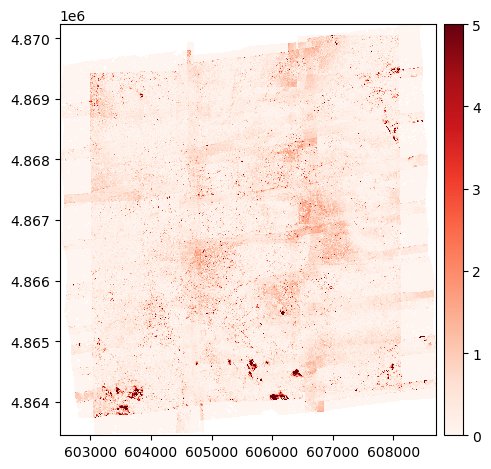

In [13]:
nmad_fn = dem_fn.replace('_DEM.tif', '_nmad_mos.tif')
nmad = gu.Raster(nmad_fn).reproject(dem)
nmad.plot(cmap='Reds', vmin=0, vmax=5)

In [ ]:
dem_fn.replace('_DEM.tif', '_nmad_mos.tif')

'/Volumes/LaCie/raineyaberle/Research/PhD/Skysat-Stereo/study-sites/MCS/20240420/coregAll_ba-u5m_2baRounds_MCS_20240420_DEM.tif'

## Slope correction

In [ ]:
if (site_name=='MCS') & (date=='20241003'):
    dem_slopecorr_zshift_fn = dem_zshift_fn.replace('.tif', '_slope-corrected.tif')
    if not os.path.exists(dem_slopecorr_zshift_fn):
        # Load inputs
        refdem = xdem.DEM(refdem_fn).reproject(dem_zshift)
        ss_mask = gu.Raster(ss_mask_fn).reproject(dem_zshift)
        ss_mask = (ss_mask==1)
        gcp = gu.Vector(gcp_fn).reproject(dem_zshift)
        if site_name=='JacksonPeak':
            gcp = gcp.buffer(4)
        gcp = gcp.create_mask(dem_zshift)
        
        # Slope correction
        corr = xdem.coreg.TerrainBias(terrain_attribute="slope", fit_or_bin='bin').fit(refdem, dem_zshift, ss_mask)
        dem_slopecorr = corr.apply(dem_zshift)
        ddem_slopecorr = dem_slopecorr - refdem
        
        # Apply vertical shift to DEM using GCP
        shift = xdem.coreg.VerticalShift().fit(refdem, dem_slopecorr, gcp)
        zshift = shift.meta['outputs']['affine']['shift_z'] + gcp_elev
        print(f"Vertical shift = {np.round(float(zshift),2)} m")
        dem_slopecorr_zshift = dem_slopecorr + zshift   
        ddem_slopecorr_zshift = ddem_slopecorr + zshift
        
        # Calculate slope errors after
        corr_after = xdem.coreg.TerrainBias(terrain_attribute='slope', fit_or_bin='bin').fit(refdem, dem_slopecorr_zshift, ss_mask)
        
        # Calculate stable surface stats
        ddem_slopecorr_zshift_ss = ddem_slopecorr_zshift[ss_mask]
        ss_median, ss_nmad = np.ma.median(ddem_slopecorr_zshift_ss), xdem.spatialstats.nmad(ddem_slopecorr_zshift_ss)
        
        # Plot
        fig, ax = plt.subplots(2, 2, figsize=(10,10), gridspec_kw={'height_ratios': [2,1]})
        ax = ax.flatten()
        bins = np.arange(-5, 5.2, 0.5)
        ddem_slopecorr_zshift.plot(cmap='coolwarm_r', vmin=-5, vmax=5, ax=ax[0])
        ax[1].hist(ddem_slopecorr_zshift.data.ravel(), color='gray', edgecolor='k', linewidth=0.5, 
                bins=bins, label='All surfaces')
        ax[1].hist(ddem_slopecorr_zshift_ss.data.ravel(), color='m', edgecolor='k', linewidth=0.5, 
                bins=bins, label='Stable surfaces')
        ax[1].text(0.05, 0.9, f"SS median = {np.round(float(ss_median),2)} m", transform=ax[1].transAxes)
        ax[1].text(0.05, 0.85, f"SS NMAD = {np.round(float(ss_nmad),2)} m", transform=ax[1].transAxes)
        ax[1].set_xlim(bins[0], bins[-1])
        ax[1].set_xlabel('Elevation residuals [m]')
        ax[1].set_ylabel('Frequency')
        ax[1].legend(loc='center left')
        for axis, f in zip(ax[2:], [corr, corr_after]):
            meta_df = f.meta['outputs']['fitorbin']['bin_dataframe']
            meta_df['bin_center'] = [(x.left + x.right) / 2 for x in meta_df['slope']]
            meta_df.plot(x='bin_center', y='nanmedian', ax=axis)
            axis.set_xticks(np.arange(0,91,10))
        ax[2].set_title('Slope bias before')    
        ax[3].set_title('Slope bias after')
        fig.tight_layout()
        plt.show()
        
        # Save slope-corrected DEM and to file
        dem_slopecorr_zshift.save(dem_slopecorr_zshift_fn)
        print('Slope-corrected DEM saved to file:', dem_slopecorr_zshift_fn)
        fig_fn = dem_slopecorr_zshift_fn.replace('.tif', '.png')
        fig.savefig(fig_fn, dpi=250, bbox_inches='tight')
        print('Figure saved to file:', fig_fn)
        
    else:
        dem_slopecorr_zshift = xdem.DEM(dem_slopecorr_zshift_fn)
        print('Slope-corrected DEM loaded from file.')

else:
    print('Not a snow-free DEM, skipping.')

## Construct snow depth map

In [ ]:
sd_fn = os.path.splitext(dem_zshift_fn)[0] + '_snow_depth.tif'
if not os.path.exists(sd_fn):
    # Load input files
    # use slope-corrected file for the snow free
    dem = xdem.DEM(dem_zshift_fn)
    refdem = xdem.DEM(refdem_fn).reproject(dem)
    snow_mask = gu.Raster(snow_mask_fn).reproject(dem)
    snow_mask = (snow_mask == 1)
    
    # Calculate dDEM
    ddem = dem - refdem
    
    # Mask snow-free surfaces
    ddem.set_mask(~snow_mask)
    
    # Save to file
    ddem.save(sd_fn)
    print('Snow depth map saved to file:', sd_fn)
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ddem.plot(cmap='Blues', vmin=0, vmax=6, ax=ax[0], cbar_title='Snow depth [m]')
    ax[1].hist(ddem.data.ravel(), bins=np.arange(-1,6.1, step=0.2), facecolor='skyblue', edgecolor='k', linewidth=0.5)
    ax[1].set_yticks([])
    ax[1].set_xlabel('Snow depth [m]')
    ax[1].set_xlim(-1,6)
    fig.tight_layout()
    plt.show()
    
else:
    print('Snow depth map already exists in file, skipping.')
    

## Save stable surfaces and SNOTEL errors

In [ ]:
error_stats_fn = os.path.join(data_dir, site_name, date, 'post_process', os.path.splitext(os.path.basename(dem_zshift_fn))[0] + '_error_stats.csv')
if not os.path.exists(error_stats_fn):
    # Load DEMs
    # dem_fn = os.path.join(data_dir, site_name, date, 'post_process', f'{site_name}_{date}_DEM_GCPshift.tif')
    # use slope-corrected for the snow-free DEM
    if (site_name=='MCS') & (date=='20241003'):
        dem = xdem.DEM(dem_slopecorr_zshift_fn)
    else:
        dem = xdem.DEM(dem_zshift_fn)
    refdem = xdem.DEM(refdem_fn).reproject(dem)
    
    # Calculate dDEM
    ddem = dem - refdem
    
     # Calculate stable surface errors
    ss_mask = gu.Raster(ss_mask_fn).reproject(dem)
    ss_mask = (ss_mask==1)
    ddem_ss = ddem[ss_mask]
    ddem_ss_median, ddem_ss_nmad = np.ma.median(ddem_ss), xdem.spatialstats.nmad(ddem_ss)
    
    # Calculate SNOTEL errors
    snotel_site_fn = os.path.join(data_dir, site_name, "snotel", f"{site_name}_SNOTEL_site_info.csv")
    snotel_site = pd.read_csv(snotel_site_fn)
    snotel_site['geometry'] = wkt.loads(snotel_site['geometry'])
    snotel_site = gpd.GeoDataFrame(snotel_site, crs='EPSG:4326')
    snotel_site = gu.Vector(snotel_site).reproject(dem).buffer(5)
    try:
        snotel_mask = snotel_site.create_mask(dem)
        # Determine SNOTEL snow depth
        if site_name=="Banner":
            snotel_sd = 1.22
        elif (site_name=="MCS") & (date=="20240420"):
            snotel_sd = 1.27
        elif (site_name=="MCS") & (date=="20241003"):
            snotel_sd = 0.0
        elif site_name=="JacksonPeak":
            snotel_sd = 1.45
        ddem_snotel = ddem[snotel_mask]
        ddem_snotel_median, ddem_snotel_nmad = np.ma.median(ddem_snotel) - snotel_sd, xdem.spatialstats.nmad(ddem_snotel)
    except:
        ddem_snotel_median, ddem_snotel_nmad = None, None
        
    print(ddem_ss_median, ddem_ss_nmad)
    print(ddem_snotel_median, ddem_snotel_nmad)
    
    # Compile in dataframe
    errors_df = pd.DataFrame({'stable_surfaces_median_m': [ddem_ss_median],
                              'stable_surfaces_NMAD_m': [ddem_ss_nmad],
                              'SNOTEL_median_m': [ddem_snotel_median],
                              'SNOTEL_NMAD_m': [ddem_snotel_nmad]})
    errors_df.to_csv(error_stats_fn, index=False)
    print('Error stats saved to file:', error_stats_fn)


## Calculate terrain parameters and averaging windows

In [ ]:
# Averaging windows
res_dict_fn = os.path.join(data_dir, site_name, 'refdem', 'refdem_terrain_sampling_resolutions.json')
if not os.path.exists(res_dict_fn):
    # Load DEMs
    refdem = xdem.DEM(refdem_fn).reproject(dem)

    # Estimate averagine windows (correlation ranges)
    res_dict = pp.calculate_terrain_parameters(refdem)
    with open(res_dict_fn, 'w') as f:
        json.dump(res_dict, f)
    print('Terrain sampling resolutions saved to file:', res_dict_fn)
else:
    print('Estimated terrain averaging dictionary already exists, loaded from file.')
    with open(res_dict_fn, 'r') as f:
        res_dict = json.load(f)
    res_dict = {key: float(value) for key, value in res_dict.items()}
print('Terrain averaging windows:')
print(res_dict)

# Load wind direction
wind_fn = glob.glob(os.path.join(data_dir, site_name, "*dominant_wind_direction*.json"))[0]
with open(wind_fn, 'r') as f:
    wind = json.load(f)
wind_dir = float(wind['dominant_wind_direction_degrees'])
print(f'Dominant wind direction: {wind_dir}')

# Output file paths
elev_fn = os.path.splitext(refdem_fn)[0] + '_ELEVATION.tif'
slope_fn = os.path.splitext(refdem_fn)[0] + '_SLOPE.tif'
aspect_fn = os.path.splitext(refdem_fn)[0] + '_ASPECT.tif'
tpi_fn = os.path.splitext(refdem_fn)[0] + '_TPI.tif'
sx_fn = os.path.splitext(refdem_fn)[0] + f'_Sx_az{int(wind_dir)}.tif'

# Resample and save terrain parameters
refdem = None
elev = None

# Elevation
if not os.path.exists(elev_fn):
    if refdem is None:
        refdem = xdem.DEM(refdem_fn)
    elev = pp.resample(refdem, res_dict['elevation_sill_m'])
    elev.save(elev_fn)
    print('Resampled elevation saved to file:', elev_fn)
else:
    print('Resampled elevation already exists, skipping.')

# Slope
if not os.path.exists(slope_fn):
    if refdem is None:
        refdem = xdem.DEM(refdem_fn)
    slope = pp.resample(refdem.slope(), res_dict['slope_sill_m'])
    slope.save(slope_fn)
    print('Resampled slope saved to file:', slope_fn)
else:
    print('Resampled slope already exists, skipping.')

# Aspect
if not os.path.exists(aspect_fn):
    if refdem is None:
        refdem = xdem.DEM(refdem_fn)
    aspect = pp.resample(refdem.aspect(), res_dict['aspect_sill_m'])
    aspect.save(aspect_fn)
    print('Resampled aspect saved to file:', aspect_fn)
else:
    print('Resampled aspect already exists, skipping.')

# TPI
if not os.path.exists(tpi_fn):
    if elev is None:
        elev = xdem.DEM(elev_fn)
    tpi = xdem.terrain.topographic_position_index(elev)
    tpi.save(tpi_fn)
    print('Topographic Position Index (TPI) saved to file:', tpi_fn)
else:
    print('Topographic Position Index (TPI) already exists, skipping.')

# Sx
if not os.path.exists(sx_fn):
    import xarray as xr
    from topo_descriptors import topo
    if elev is None:
        elev = xdem.DEM(elev_fn)
    x_coords, y_coords = elev.coords()[0][0, :], elev.coords()[1][:, 0]
    elev_da = xr.DataArray(data=elev.data, coords={'y': y_coords, 'x': x_coords})
    elev_ds = elev_da.to_dataset(name="elevation").assign_attrs({'crs': f"EPSG:{elev.crs.to_epsg()}"})
    sx_200m = topo.sx(elev_ds, azimuth=wind_dir, radius=200)
    sx = xr.DataArray(sx_200m, coords=elev_ds.coords).rio.write_crs(elev.crs)
    sx.rio.to_raster(sx_fn)
    print('Sx saved to file:', sx_fn)
else:
    print('Sx already exists, skipping.')
